#### Trend analyisis of Covid-19
###### Background
Coronavirus disease (COVID-19) is an infectious disease caused by a new virus.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. You can protect yourself by washing your hands frequently, avoiding touching your face, and avoiding close contact (1 meter or 3 feet) with people who are unwell.
######  HOW IT SPREADS
Coronavirus disease spreads primarily through contact with an infected person when they cough or sneeze. It also spreads when a person touches a surface or object that has the virus on it, then touches their eyes, nose, or mouth.
##### Prevention
There’s currently no vaccine to prevent coronavirus disease (COVID-19)
You can protect yourself and help prevent spreading the virus to others if you:
Do
* Wash your hands regularly for 20 seconds, with soap and water or alcohol-based hand rub
* Cover your nose and mouth with a disposable tissue or flexed elbow when you cough or sneeze
* Avoid close contact (1 meter or 3 feet) with people who are unwell
* Stay home and self-isolate from others in the household if you feel unwell
Don't
* Touch your eyes, nose, or mouth if your hands are not clean


In [213]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [214]:
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot') # optional: for ggplot-like style

* Some one collected the Covid-19 data and stored it in the github respository below.

In [215]:
##the data us stored here.
df=pd.read_csv('https://raw.githubusercontent.com/datasets/covid-19/master/data/countries-aggregated.csv',sep=',')

In [216]:
#check the top 5 results
df.tail()

,Date,Country,Confirmed,Recovered,Deaths
12277,2020-03-30,Venezuela,135,39,3
12278,2020-03-30,Vietnam,203,55,0
12279,2020-03-30,West Bank and Gaza,116,18,1
12280,2020-03-30,Zambia,35,0,0
12281,2020-03-30,Zimbabwe,7,0,1


##### Put data into ssql lite to take advantages of window functions.e.g for calulating the number of days since the country first reported a case.
I coudnt do it using pandas...i used sql windows functions

In [217]:
import sqlite3
conn = sqlite3.connect('Covid-19.db')
c = conn.cursor()

#### Create a table for storing the data in sqlite db

In [218]:
c.execute('CREATE TABLE IF NOT EXISTS covid_cases (Date text, Country text,Confirmed number,Recovered number,Deaths number)')
conn.commit()

##### Transfer data to sqlite table...

In [219]:
df.to_sql('covid_cases', conn, if_exists='replace', index = False)

###### Here the sql windows functions that adds the count of days since the country first reported a case

In [220]:
c.execute("""SELECT Date,Country,Confirmed,Recovered,Deaths,
    DENSE_RANK()Over(PARTITION BY Country order by Date Asc) as Days
    from covid_cases  where Confirmed<>0""")


In [221]:
results = c.fetchall()
#print(results[0:2])
df = pd.DataFrame(results, columns=['Date','Country','Confirmed','Recovered','Deaths','Days'])    
#print (df1.head(3))

In [222]:
c.close()

In [223]:
df['Date']=pd.to_datetime(df['Date'])

In [224]:
#get top 200 confirmed cases and find the countries 
df_max=df.sort_values(['Confirmed'],ascending=False)[:201]

In [225]:
countries=df_max['Country'].unique()

In [226]:
countries

array(['US', 'Italy', 'Spain', 'China', 'Germany', 'France', 'Iran',
       'United Kingdom', 'Switzerland', 'Belgium', 'Netherlands',
       'Turkey', 'Korea, South', 'Austria'], dtype=object)

In [227]:

df=df.sort_values(['Date'],ascending=False)

* #### Here, i get a table(dataframe) for each of the identified countries and store it in a list.

In [228]:
#get a dataframe for each country
list_top_df=[]
for c in countries:
    #put name
    name='df_'+c
    #print(name)  
    list_top_df.append(df[(df['Country']==c)])  


* #### Then we add additional three columns (computed) based on confirmed ,Deaths,and recovered

In [229]:
for l in list_top_df:
    l['Daily_Infection']=l['Confirmed']-l['Confirmed'].shift(-1)
    l['Daily_Death']=l['Deaths']-l['Deaths'].shift(-1)
    l['Daily_Recovery']=l['Recovered']-l['Recovered'].shift(-1)

##### generating random colors for the charts

In [230]:
import numpy as np
list_colors=[]
for i in range(0,len(list_top_df)):
    color = list(np.random.choice(range(256), size=3))
    color=[c/256 for c in color]      
    list_colors.append(color)      
        
          
    
print(list_colors)

[[0.34765625, 0.33203125, 0.171875], [0.65625, 0.0234375, 0.2734375], [0.65234375, 0.60546875, 0.16796875], [0.84375, 0.02734375, 0.4609375], [0.25390625, 0.1171875, 0.515625], [0.875, 0.2734375, 0.546875], [0.9296875, 0.328125, 0.27734375], [0.1953125, 0.33203125, 0.453125], [0.2109375, 0.91796875, 0.8828125], [0.52734375, 0.70703125, 0.11328125], [0.81640625, 0.328125, 0.8359375], [0.7890625, 0.50390625, 0.234375], [0.4921875, 0.38671875, 0.984375], [0.71875, 0.421875, 0.3359375]]


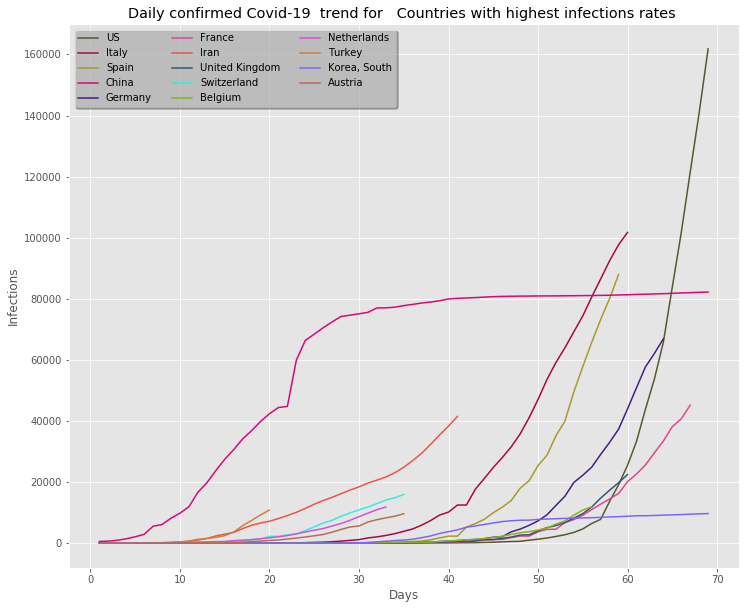

In [231]:
plt.figure(figsize=(12,10))
for i in range(0,len(list_top_df)):
    #list_top_df[i]
    plt.plot(list_top_df[i]['Days'],list_top_df[i]['Confirmed'],c= list_colors[i],label=countries[i])
    leg = plt.legend(loc='best', ncol=3 , shadow=True, fancybox=True)
    plt.title('Daily confirmed Covid-19  trend for   Countries with highest infections rates ')
    plt.ylabel("Infections")
    plt.xlabel("Days")
    leg.get_frame().set_alpha(0.5)
plt.savefig('confirmed.png')

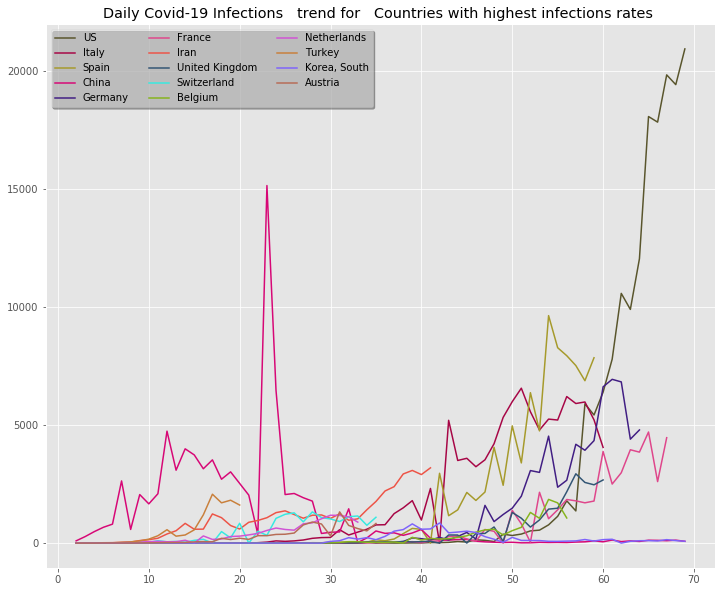

In [232]:
plt.figure(figsize=(12,10))
for i in range(0,len(list_top_df)):
    #list_top_df[i]
    plt.plot(list_top_df[i]['Days'],list_top_df[i]['Daily_Infection'],c= list_colors[i],label=countries[i])
    leg = plt.legend(loc='best', ncol=3 , shadow=True, fancybox=True)
    plt.title('Daily Covid-19 Infections   trend for   Countries with highest infections rates ')
    leg.get_frame().set_alpha(0.5)
plt.savefig('Daily_Infections.png')

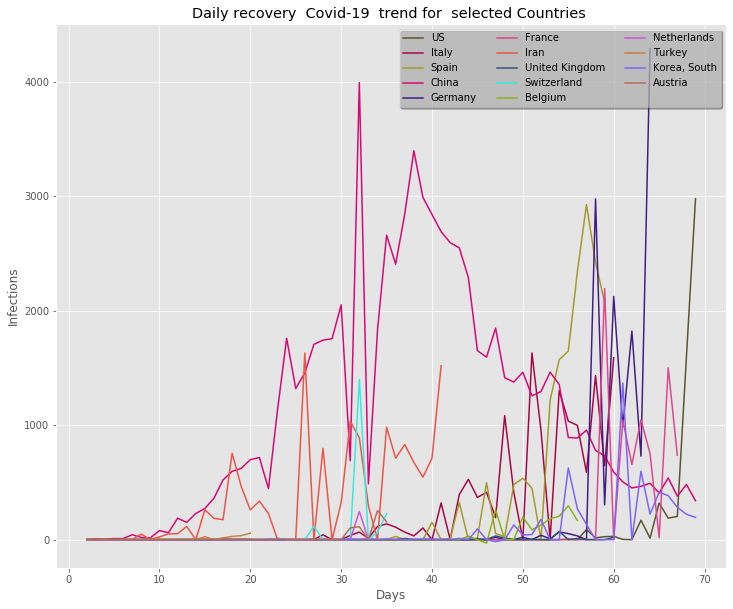

In [233]:
plt.figure(figsize=(12,10))
for i in range(0,len(list_top_df)):
    #list_top_df[i]
    plt.plot(list_top_df[i]['Days'],list_top_df[i]['Daily_Recovery'],c= list_colors[i],label=countries[i])
    leg = plt.legend(loc='best', ncol=3 , shadow=True, fancybox=True)
    plt.title('Daily recovery  Covid-19  trend for  selected Countries ')
    plt.ylabel("Infections")
    plt.xlabel("Days")
    leg.get_frame().set_alpha(0.5)
plt.savefig('confirmed.png')

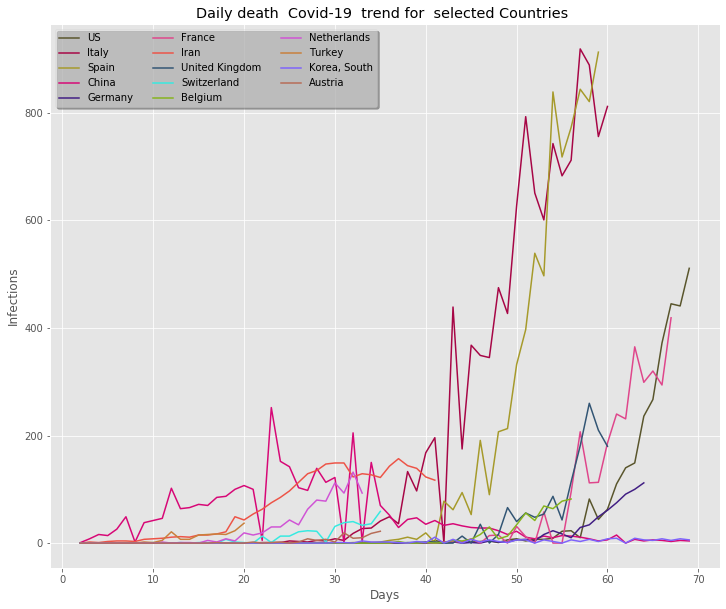

In [234]:
plt.figure(figsize=(12,10))
for i in range(0,len(list_top_df)):
    #list_top_df[i]
    plt.plot(list_top_df[i]['Days'],list_top_df[i]['Daily_Death'],c= list_colors[i],label=countries[i])
    leg = plt.legend(loc='best', ncol=3 , shadow=True, fancybox=True)
    plt.title('Daily death  Covid-19  trend for  selected Countries ')
    plt.ylabel("Infections")
    plt.xlabel("Days")
    leg.get_frame().set_alpha(0.5)
plt.savefig('confirmed.png')

###### East Africa Countries

In [235]:
#countries=df_max['Country'].unique()
countries=['Uganda','Kenya','Tanzania','Rwanda']

In [236]:
countries

['Uganda', 'Kenya', 'Tanzania', 'Rwanda']

In [237]:
import numpy as np
list_colors=[]
for i in range(0,len(list_top_df)):
    color = list(np.random.choice(range(256), size=3))
    color=[c/256 for c in color]      
    list_colors.append(color)      
        
          
    
print(list_colors)

[[0.75, 0.9765625, 0.4921875], [0.98828125, 0.39453125, 0.44921875], [0.5078125, 0.81640625, 0.0234375], [0.2578125, 0.65234375, 0.15234375], [0.40234375, 0.75, 0.88671875], [0.875, 0.66015625, 0.5859375], [0.66015625, 0.1796875, 0.06640625], [0.75, 0.421875, 0.27734375], [0.75390625, 0.46875, 0.796875], [0.07421875, 0.2734375, 0.3671875], [0.3203125, 0.171875, 0.41796875], [0.390625, 0.6875, 0.59765625], [0.58984375, 0.328125, 0.046875], [0.1640625, 0.8125, 0.125]]


In [238]:
#get a dataframe for each country
list_top_df=[]
for c in countries:
    #put name
    name='df_'+c
    #print(name)  
    list_top_df.append(df1[(df1['Country']==c)])  

In [239]:
#list_top_df[0]

In [240]:
for l in list_top_df:
    l['Daily_Infection']=l['Confirmed']-l['Confirmed'].shift(-1)
    l['Daily_Death']=l['Deaths']-l['Deaths'].shift(-1)
    l['Daily_Recovery']=l['Recovered']-l['Recovered'].shift(-1)

In [241]:
def get_color(c):
        switcher={
                'China':'red',
                'Italy':'green',
                'US':'yellow',
                'Spain':'blue',
                'Germany':'orange',
                'France':'Purple',
                'Iran':'grey'
             }
        return switcher.get(c)

In [242]:
#generating random colors failed to generate distinct colors.
# So i opted for hard coding the countries color


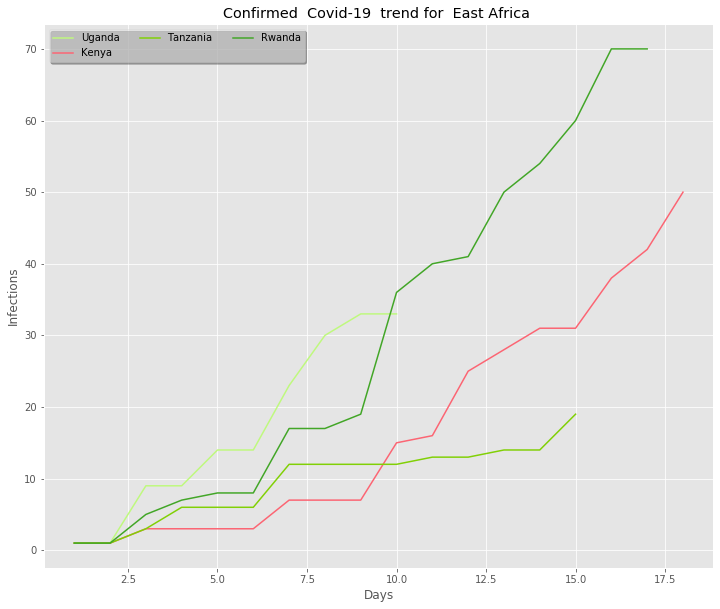

In [243]:
plt.figure(figsize=(12,10))
for i in range(0,len(list_top_df)):
    #list_top_df[i]
    plt.plot(list_top_df[i]['Days'],list_top_df[i]['Confirmed'],c= list_colors[i],label=countries[i])
    leg = plt.legend(loc='best', ncol=3 , shadow=True, fancybox=True)
    plt.title('Confirmed  Covid-19  trend for  East Africa ')
    plt.ylabel("Infections")
    plt.xlabel("Days")
    leg.get_frame().set_alpha(0.5)
plt.savefig('confirmed.png')

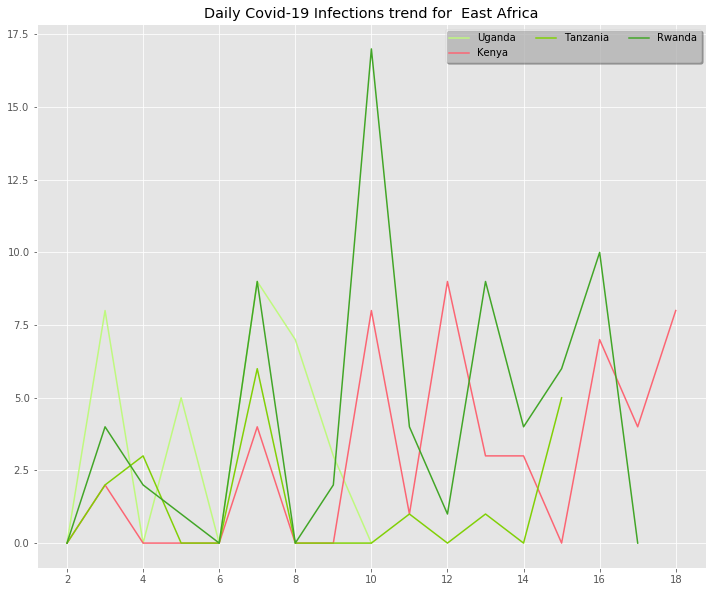

In [244]:
plt.figure(figsize=(12,10))
for i in range(0,len(list_top_df)):
    #list_top_df[i]
    plt.plot(list_top_df[i]['Days'],list_top_df[i]['Daily_Infection'],c= list_colors[i],label=countries[i])
    leg = plt.legend(loc='best', ncol=3 , shadow=True, fancybox=True)
    plt.title('Daily Covid-19 Infections trend for  East Africa')
    leg.get_frame().set_alpha(0.5)
plt.savefig('Daily_Infections.png')